In [10]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from data import *
from baseline_smc import *
from plots import *
from torch.distributions.dirichlet import Dirichlet
from torch.distributions.normal import Normal
import sys
import datetime
import time 
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

('probtorch:', '0.0+5a2c637', 'torch:', '1.0.0.dev20181029', 'cuda:', True)


In [11]:
## Dataset parameters
num_series = 1
## range of length of tracjectories, need to be positive integers
T_min = 50
T_max = 60
K = 4
D = 2
dt = 5
Boundary = 30
noise_ratio = 2.0

## Model Parameters
num_particles = 50
num_particles_smc = 30
NUM_HIDDEN_TRANS = 32
NUM_LATENTS_TRANS = K*K
NUM_OBS_TRANS = 2 * D

#
NUM_PIXELS = 28*28
NUM_HIDDEN_VAE = 128
NUM_LATENT_VAE = 2
NUM_SAMPLES = 50


NUM_EPOCHS = 400
LEARNING_RATE = 1e-3
CUDA = False
RESTORE = False
PATH_ENC = "weights/1shot_enc-%dIS-enc-%s" % (num_particles, datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))

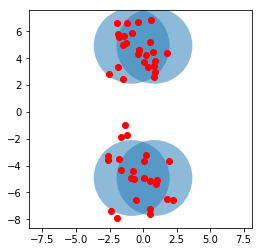

In [12]:
T = 50
noise_cov = np.array([[1, 0], [0, 1]]) * noise_ratio       
init_v = np.random.random(2) * np.random.choice([-1,1], size=2)
v_norm = ((init_v ** 2 ).sum()) ** 0.5 ## compute norm for each initial velocity
init_v = init_v / v_norm * dt ## to make the velocity lying on a circle
STATE, mu_ks, cov_ks, Pi, Y, A_true, Zs_true = generate_seq(T, K, dt, Boundary, init_v, noise_cov)

plot_clusters(Y.data.numpy(), mu_ks.data.numpy(), cov_ks.data.numpy(), K)

In [6]:
class Trans_Encoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS_TRANS,
                       num_hidden=NUM_HIDDEN_TRANS,
                       num_latents=NUM_HIDDEN_TRANS):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh())
        self.latent_dir = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs, prior):
        A_sample = torch.zeros((K, K))
        hidden = self.enc_hidden(obs)
        variational = F.softmax(self.latent_dir(hidden), -1).sum(0).view(K, K) + prior
        for k in range(K):
            A_sample[k] = Dirichlet(variational[k]).sample()
        return variational, A_sample
    

 ## VAE
class Encoder(nn.Module):
    def __init__(self, num_pixels=NUM_PIXELS, 
                       num_hidden=NUM_HIDDEN_VAE,
                       num_latent=NUM_LATENT_VAE):
        super(self.__class__, self).__init__()

        self.enc_hidden = nn.Sequential( 
                            nn.Linear(num_pixels, num_hidden),
                            nn.ReLU(),
                            nn.Linear(num_hidden, num_hidden),
                            nn.ReLU())
        
        self.z_mean = nn.Linear(num_hidden, num_latent)
        self.z_log_std = nn.Linear(num_hidden, num_latent)
        
    def forward(self, images, num_samples=NUM_SAMPLES):
        hiddens = self.enc_hidden(images)
        latents_means = self.z_mean(hiddens),
        latents_std = self.z_log_std(hiddens).exp()
        Normal(latents_means, latents_std).sample(())
        return q   

NameError: name 'expand_inputs' is not defined

In [ ]:
def initialize():
    enc = Encoder()
    if CUDA:
        enc.cuda()
    optimizer =  torch.optim.Adam(list(enc.parameters()),lr=LEARNING_RATE)    
    return enc, optimizer
enc, optimizer = initialize()

In [ ]:
KLs = []
EUBOs = []
ESSs = []
ELBOs = []
for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    optimizer.zero_grad()
    alpha_trans_0 = initial_trans_prior(K)
    init_v = init_velocity(dt)
    T = np.random.randint(T_min, T_max)
    STATE, mu_ks, cov_ks, Pi, Y, A_true, Zs_true = generate_seq(T, K, dt, Boundary, init_v, noise_cov)
    enc, eubo, kl, ess, variational, elbo = oneshot_sampling(enc, alpha_trans_0, Pi, mu_ks, cov_ks, Y, T, D, K, num_particles, num_particles_smc)
    eubo.backward()
    KLs.append(kl.item())
    EUBOs.append(eubo.item())
    ESSs.append(ess)
    ELBOs.append(elbo.item())
#     log_qs.append(loss_infer.item())
    optimizer.step()
    time_end = time.time()
    print('epoch : %d, eubo : %f, elbo : %f,  KL : %f (%ds)' % (epoch, eubo, elbo, kl, time_end - time_start))

if RESTORE:
    enc.load_state_dict(torch.load(PATH_ENC))
else:
    torch.save(enc.state_dict(), PATH_ENC)
    save_params(KLs, EUBOs, ESSs, PATH_ENC)

In [ ]:
# plot_dirs(variational, alpha_trans_0, Zs_true, T, K, vmax=15)

In [ ]:
# conjugate_post = alpha_trans_0 + pairwise(Z_true, T).sum(0)
# variational = alpha_trans_0 + latents_dirs
# conjugate_post.sum()

In [ ]:
def plot_results(EUBOs, ELBOs, KLs, ESSs, PATH_ENC):
    fig, ax = plt.subplots(figsize=(16, 8))
    ax1 = fig.add_subplot(1,2,1)
    x = np.arange(len(EUBOs))
    ax1.plot(EUBOs, 'r-', label='eubo')
    ax1.plot(ELBOs, 'b-', label='elbo')
    ax1.plot(KLs, 'g-', label='KL')
    ax1.legend()
    ax1.set_xlabel('epochs')
    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(np.array(ESSs))
    fig.savefig(PATH_ENC + 'results.png')

plot_results(EUBOs, ELBOs, KLs, ESSs, PATH_ENC)

In [ ]:
init_v = init_velocity(dt)
T = np.random.randint(T_min, T_max)
STATE, mu_ks, cov_ks, Pi, Y, A_true, Zs_true = generate_seq(T, K, dt, Boundary, init_v, noise_cov)

Y_pairwise = torch.cat((Y[:-1].unsqueeze(0), Y[1:].unsqueeze(0)), 0).transpose(0, 1).contiguous().view(T-1, 2*D)
variational, A_sample = enc(Y_pairwise, alpha_trans_0)
Zs, log_weights, log_normalizer = smc_hmm(Pi, A_sample, mu_ks, cov_ks, Y, T, D, K, num_particles_smc)
Z_ret = resampling_smc(Zs, log_weights)

In [ ]:
np.around(torch.cat((Z_ret, Y), -1).data.numpy(), 2)